# Two dimensional unequal sampling generalized prolates

This example is not unlike the 2D example of Bronez. We don't have the data, but here goes.

In [28]:
using FFTW, IterTools, Plots, LinearAlgebra, KrylovKit, FINUFFT


""" 

    dfn(x, y, bet)

The underlying Kernel function, equation 22-23 in Chave

# Arguments
    - `x::Number` 1-dimensional location
    - `y::Number` 1-dimensional location
    - `bet::Number` 1-dimensional bandwidth

# Outputs
    - Kernel evaluated between the two points x, y
"""
function dfn(x, y, bet)
  x == y && return 2*bet
  sin(2 * pi * bet * (x - y))/(pi * (x - y))
end

""" 

    efn(x, y, f)

The FT matrix

# Arguments
    - `x::Vector` d-dimensional location
    - `y::Vector` d-dimensional location
    - `f::Vector` d-dimensional frequency

# Outputs
    - Frequency-dependent kernel evaluated between the two points x, y
"""
function efn(x, y, f)
    x == y && return 1.0
    f == 0.0 && return 1.0
    exp(-2.0im * pi * f * (x - y))
end

# Product of efn and dfn
function bfn(x, y, f, bet)
    efn(x, y, f) * dfn(x, y, bet)
end

bfn (generic function with 2 methods)

# Warmup: Missing data problem in 1D

In [29]:
NN = 256
tt = (1.0:NN).^(1.05)

fB = 1.0/2 # *ones(d)
fA = 1.0/8 # *ones(d)

f = 0.0

RA = [dfn(xy..., fA) for xy in IterTools.product(tt, tt)]
RB = [bfn(xy..., f, fB) for xy in IterTools.product(tt, tt)]

neig = geneigsolve(x->(RA*x, RB*x), 256, ishermitian = true, isposdef = true)

([0.999999999988216], [[-6.22852809202261e-5, -0.00042392389855827503, -0.001726805458640207, -0.005293765288850428, -0.01332648374292853, -0.028797773299069705, -0.05481774134144519, -0.09343136262410295, -0.14411886763618212, -0.20263362646825103  …  0.0018069228313691511, 0.01225475549702544, 0.01743116079612641, 0.017033257726227432, 0.013046558777001054, 0.008089171356716152, 0.004041083100702273, 0.0015696453227161886, 0.00043396232139586346, 6.657096795584709e-5]], ConvergenceInfo: no converged values after 100 iterations and 3101 applications of the linear map;
norms of residuals are given by (2.2255892526004856e-8,).
)

In [30]:
using Multitaper

lam, u = Multitaper.gpss_orth(fA, 1, tt, 0.0, beta = fB)

([1.000000000000005], [-1.3147448552070696e-7; -1.2968722460982981e-6; … ; -3.4966999173515546e-7; -2.5056211622125368e-31])

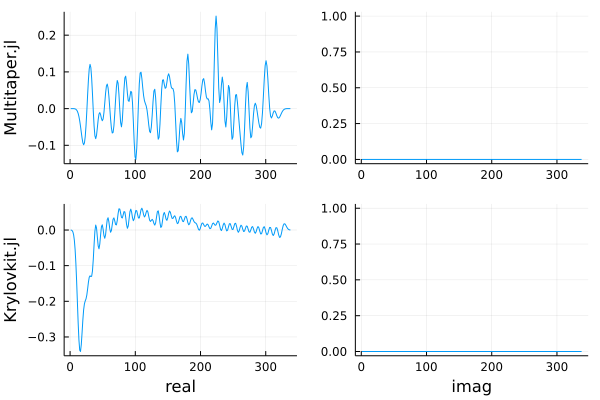

In [31]:
plot(plot(tt, real.(u)), plot(tt, imag.(u)), plot(tt, real.(neig[2][1])), plot(tt, imag.(neig[2][1])),
    layout = (2,2), xlabel = ["" "" "real" "imag"], ylabel = ["Multitaper.jl" "" "Krylovkit.jl" ""], 
    legend = false)

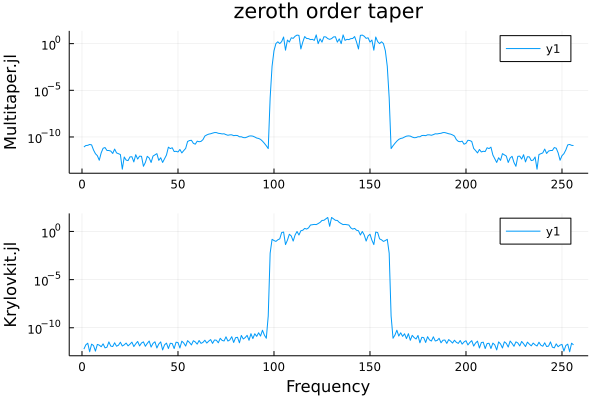

In [5]:
K = 1
w = fA
freqs = LinRange(-0.5, 0.5, NN+1)[1:NN]

ftsleps = mapreduce(k->abs2.(nufft1d3(2*pi*tt, ComplexF64.(u[:,k]), -1, 1e-15, collect(freqs))),hcat, 1:K)

ftsleps2 = abs2.(nufft1d3(2*pi*tt, ComplexF64.(neig[2][1]), -1, 1e-15, collect(freqs)))

plot(plot(ftsleps, yscale = :log10), plot(ftsleps2, yscale = :log10), layout = (2,1), 
    title = ["zeroth order taper" ""], xlabel = ["" "Frequency"], ylabel = ["Multitaper.jl" "Krylovkit.jl"])

# Warmup: Missing data problem in 2D

This is like the data in the Chave paper, only 2D. Gaps. 

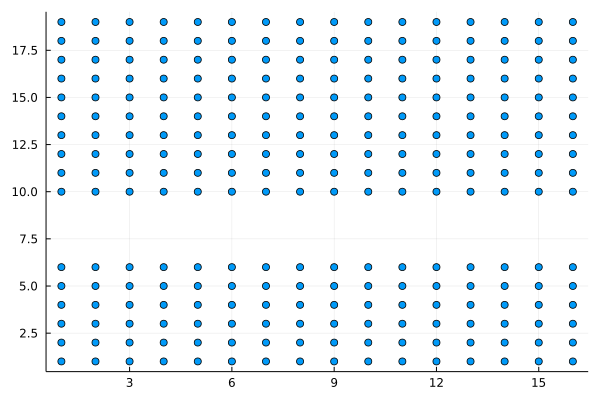

In [16]:
N1 = 16
N2 = 16
t1 = collect(1:N1)
t2 = collect(1:(N2 + 3))[vcat(collect(1:6), collect(10:19))]

mdpts = [(r,t) for r in t1 for t in t2]
mdlocs = [[r,t] for r in t1 for t in t2]

scatter(mdpts, legend = false)

In [17]:
fB = 1.0/2 
fA = 1.0/8 

RA = [dfn(xy..., fA) for xy in IterTools.product(mdlocs, mdlocs)]
RB = [dfn(xy..., fB) for xy in IterTools.product(mdlocs, mdlocs)]

gs = geneigsolve(x->(RA*x, RB*x), 256, ishermitian = true, isposdef = true) #, howmany = 1, which = :LM, issymmetric = true, T = ComplexF64)

LoadError: [91moperator does not appear to be hermitian: diagonal element NaN[39m

In [18]:
heatmap(t1, t2, reshape(gs[2][1], (16, 16)), title = "Largest eigenvector (k=0)")

LoadError: [91mUndefVarError: gs not defined[39m

# General problem: Unequal spacing in array

Here is an array similar to the example in the original Bronez paper. 

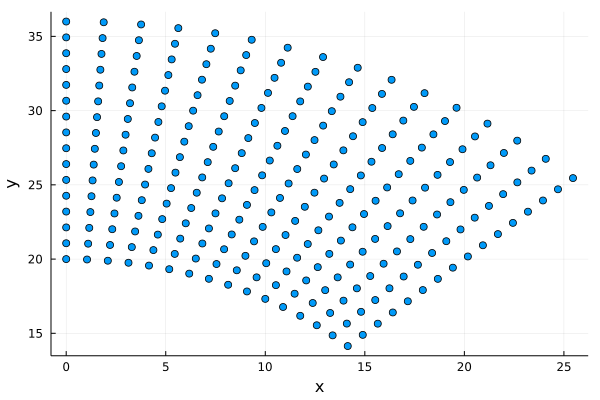

In [20]:
# Set up the array
N1 = 16
N2 = 16

# generate 32 ocncentric circles
rad = collect(LinRange(20,36.0,N1))
thet = collect(LinRange(0.0,45,N2)*pi/180)

pts1 = [(r*sin(t), r*cos(t)) for r in rad for t in thet]

locs1 = [[r*sin(t), r*cos(t)] for r in rad for t in thet]

scatter(pts1, legend = false, xlabel="x", ylabel="y")

In [22]:
# Get the RA and RB matrices, simplifications are provided by Chave, 2020 p 8
d = 2

fB = 1.0/2 # *ones(d)
fA = 1.0/8 # *ones(d)

f = 0.1

RA = [dfn(xy..., fA) for xy in IterTools.product(locs1, locs1)]
RB = [bfn(xy..., [fB, f]) for xy in IterTools.product(locs1, locs1)]

neig = geneigsolve(x->(RA*x, RB*x), 256, ishermitian = true, isposdef = true) #, howmany = 1, which = :LM, issymmetric = true, T = ComplexF64)

([0.9999999997151198], Array{Complex{Float64},1}[[-0.0002732506929924276 - 0.00040965598217163204im, 0.008810985358102008 - 0.006486118965632324im, -0.0010918398383925093 - 0.0015529434265207417im, 0.0005337936631245708 + 0.002475014516414649im, -0.0032879015173877756 - 0.003106995336505975im, -5.041856359698489e-5 - 0.0050388010682541765im, -0.0007205845433857878 - 0.005218205352327581im, 0.0008432357428034559 - 0.01088358939717647im, -0.0033710122535202673 - 0.006404668061455476im, -0.00205738819829419 - 0.007789613543822803im  …  0.003333451345886499 - 0.0034182335223038296im, 0.0013966313576354984 - 0.0005770480629417957im, -0.0022103761660985178 + 0.0006810922669468327im, 0.00155627803863509 - 0.002718784670932742im, -0.002963771226973655 + 0.0025952835574581546im, -0.002719166411283456 + 0.0009902032189772838im, -0.0026152730046432836 + 0.0007471142596287448im, 0.0022456989357035433 - 0.0012079571752962354im, 0.005005725449466787 - 0.0033680734771805634im, -0.005103720476442047 +

In [23]:
xx = hcat(locs1...)

2×256 Array{Float64,2}:
  0.0   1.04672   2.09057   3.12869  …  21.1603  22.6555  24.0887  25.4558
 20.0  19.9726   19.8904   19.7538      29.1246  27.9773  26.7532  25.4558

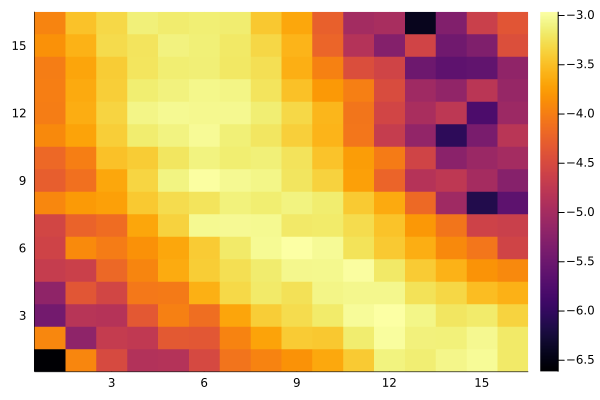

In [24]:
# This is deformed though, so it is hard to visualize with a heatmap
heatmap(log10.(abs2.(reshape(neig[2][1], (16, 16)))))

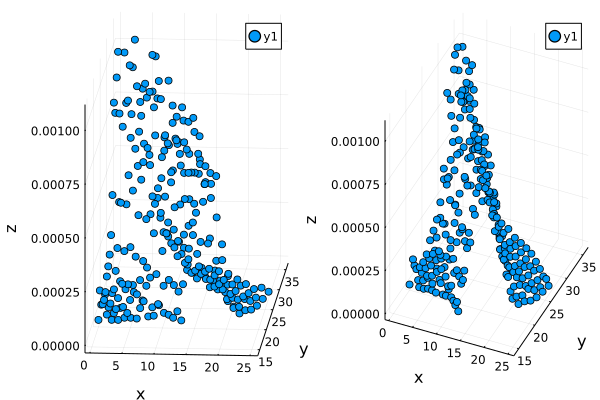

In [25]:
# could do a mesh too
pa = scatter(xx[1,:], xx[2,:], abs2.(neig[2][1]), camera = (10, 35), xlabel = "x", ylabel = "y", zlabel="z")

pb = scatter(xx[1,:], xx[2,:], abs2.(neig[2][1]), camera = (30, 50), xlabel = "x", ylabel = "y", zlabel="z")

plot(pa, pb, layout = (1,2))

In [26]:
freqs1 = LinRange(-1, 1.0, N1)
freqs2 = LinRange(-1, 1.0, N2)

ff = vcat([[xy[1] xy[2]] for xy in IterTools.product(freqs1, freqs2)][:]...)

XX = abs2.(nufft2d1(2*pi*(xx[1,:] .- 12.5)/25., 2*pi*(xx[2,:] .- 12.5)/25., 
        ComplexF64.(neig[2][1]), -1, 1e-15, 2*N1, 2*N2))

#=
nufft2d3(xj      :: Array{Float64}, 
         yj      :: Array{Float64},
         cj      :: Array{ComplexF64}, 
         iflag   :: Integer, 
         eps     :: Float64,
         sk      :: Array{Float64},
         tk      :: Array{Float64}
         [, opts :: nufft_opts]
        ) -> Array{ComplexF64}
=#

#=
nufft2d1(xj      :: Array{Float64}, 
         yj      :: Array{Float64}, 
         cj      :: Array{ComplexF64}, 
         iflag   :: Integer, 
         eps     :: Float64,
         ms      :: Integer,
         mt      :: Integer,
         [, opts :: nufft_opts]
        ) -> Array{ComplexF64}=#

32×32 Array{Float64,2}:
 0.00235707   0.0727246    0.0129295    …  0.165087     0.146528
 0.176553     4.98032e-9   0.00116738      0.235138     0.11095
 0.0037143    0.0152556    2.65733e-10     0.141495     0.0895101
 0.00786297   0.00310287   0.00567082      0.0645259    0.0235506
 3.89576e-5   0.00219319   0.00212853      0.0281044    0.00349844
 0.00877126   0.00348946   0.00307489   …  0.0098411    0.00119024
 0.00053814   0.000840363  0.00174703      0.000104658  0.00438779
 0.00301291   0.000662857  0.000921877     0.00196223   0.00203328
 0.00985119   0.00511255   0.004252        0.0017883    0.000228184
 0.000330442  0.000546471  0.000801108     0.000298657  0.000769639
 0.00493212   0.00289873   0.000796885  …  0.00050687   0.00226013
 0.00442512   0.00247198   0.00165153      1.3665e-5    0.00251429
 0.000478965  0.00196217   0.000832816     0.00104705   0.003901
 ⋮                                      ⋱  ⋮            
 0.00334707   0.00275337   0.00016784   …  0.0026509   

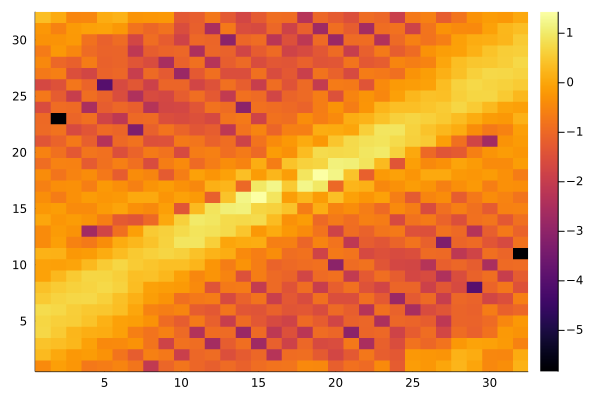

In [15]:
heatmap(log10.(XX))